# Creating a Gradio Web-based Application Powered by an AI Model

## What do we have?

1. A model that takes an image as an input and returns a label/category.
2. A space on Hugging Face that can host this model and let people interact with it on the web.

## What do we need to do next?

1. Modify the `app.py` file for the Hugging Face repository to work with the model.
2. Possibly collect some additional information about the categories that the model works for. Do you really want it to just return one word?
3. Customize the Gradio application.

## Creating code for the `app.py` script to use the model

I will walk through the process of creating the `app.py` script that we will need, but first we need to talk through the important parts.

### Parts of the base `app.py` script

- **Import Statements**  
    These are the libraries our app will need to run correctly.

- **Model Loading**  
    It's a simple line, but it is necessary.

- **Necessary Python Functions**  
    These are the functions that will convert audio recorded by the application to a spectrogram and the classify that spectrogram using our model.

- **Necessary Javascript**  
    We will need to use some javascript to make it easier for the user to record their data.

- **Translation Dictionary**  
    Our model will only output the classes as they were named when we did the training. The model used for the `[https://huggingface.co/spaces/ianhmh/lakota-color-demo](Lakota Color Demo)` outputs the categories in English, so we need to let the code know how to translate that information, and possibly attach other information to each category.

- **Custom Functions/Code**  
    You may need some custom functions to create the app you actually want, this will be a space in the code to add anything that is wanted.

- **User Interface**  
    Our user interface will be built using Gradio Blocks. These are very well documented at [https://www.gradio.app/docs], and we will look more closely at the documentation later on.}

### **Import Statements**

In [ ]:
import gradio as gr
import numpy as np
import torch
import librosa
import matplotlib.pyplot as plt
import io
from fastai.learner import load_learner
from fastai.vision.all import PILImage

### **Model Loading**

In [ ]:
# Load your model
model = load_learner("model_epoch25.pkl")

### **Necessary Python Functions**

In [ ]:
# Convert audio to image
def audio_to_melspectrogram_image(audio_data, sample_rate):
	audio_data = audio_data.astype(np.float32)
	if audio_data.ndim == 2:
		audio_data = np.mean(audio_data, axis=1)

	S = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
	S_dB = librosa.power_to_db(S, ref=np.max)

	fig, ax = plt.subplots(figsize=(4, 4))
	ax.axis('off')
	plt.imshow(S_dB, aspect='auto', origin='lower', cmap='viridis')

	buf = io.BytesIO()
	plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
	buf.seek(0)
	plt.close(fig)
	return PILImage.create(buf)

# Classification function
def classify_audio(audio):
	if audio is None:
		return "No audio provided", "", ""
	sample_rate, audio_data = audio
	image = audio_to_melspectrogram_image(audio_data, sample_rate)
	pred_class, pred_idx, probs = model.predict(image)
	prob = probs[pred_idx].item()
	color_box = f"<div style='width:100px; height:100px; background-color:{pred_class}; border:2px solid black;'></div>"
	return f"Predicted color: {pred_class}", f"Confidence: {prob:.2%}", color_box

# Dummy function for JS-only button
def noop():
	return []

### **Necessary Javascript**

In [ ]:
# JavaScript to support easy recording
record_js = """
() => {
	const inputRecBtn = document.querySelector("#audio_input .record-button");
	const inputStopRecBtn = document.querySelector("#audio_input .stop-button");

	if (inputRecBtn) {
		inputRecBtn.click();
	} 
	else if(inputStopRecBtn) {
		inputStopRecBtn.click();
	} else {
		console.log("Start/stop record button not found");
	}
}
"""

clear_js = """
() => {
	const inputClearRecBtn = document.querySelector('#audio_input button[aria-label="Clear"]');
	const inputPlayBtn = document.querySelector('#audio_input .play-pause-button');

	if (inputPlayBtn) {
		inputClearRecBtn.click();
	} else {
		console.log("Clear record button not found");
	}
}
"""

### **Translation Dictionary**

Use the cell below to create your own `category_map` values.

In [ ]:
category_map = {
            "blue": {
                "lakota": "Tho",  
                "audio": "blue.mp3"
            },
            "red": {
                "lakota": "Sa",                 
                "audio": "red.mp3"
            },
            "yellow": {
                "lakota": "Zi",  
                "audio": "zi.mp3"
            }
           }

Use the cell below to test that your `category_map` dictionary is working correctly.

In [ ]:
# Test category_map
print(category_map['blue'])
print(category_map['blue']['lakota'])
print(category_map['blue']['audio'])

### **User Interface**

In [ ]:
# Build the Gradio app
with gr.Blocks() as demo:
	with gr.Row():
		gr.Markdown("## 🎤 Record Audio and Predict a Color")

	with gr.Row():
		audio_input = gr.Audio(type="numpy", label="Recorded Audio", elem_id="audio_input", sources=["microphone"], interactive=True)
	
	with gr.Row():
		with gr.Column(scale=2):
			record_button = gr.Button("🎙️ Record Audio")
		with gr.Column(scale=1):
			clear_button = gr.Button("Clear Recording")
	
	with gr.Row():
		with gr.Column(scale=1):
			prediction_text = gr.Textbox(label="Prediction", interactive=False)
		with gr.Column(scale=1):
			confidence_text = gr.Textbox(label="Confidence", interactive=False)
		with gr.Column(scale=1):
			lakota_text = gr.Textbox(label="Lakota", interactive=False)

	with gr.Row():
		# JS-based button for auto-recording and clearing recording
		record_button.click(fn=noop, js=record_js, outputs=[])
		clear_button.click(fn=noop, js=clear_js, outputs=[])

	# Audio input triggers prediction
	audio_input.change(fn=classify_audio,
						 inputs=audio_input,
						 outputs=[prediction_text, confidence_text, lakota_text])

demo.launch()

## The full `app.py` code:

In [ ]:
import gradio as gr
import numpy as np
import torch
import librosa
import matplotlib.pyplot as plt
import io
from fastai.learner import load_learner
from fastai.vision.all import PILImage

# Load your model
model = load_learner("model_epoch25.pkl")

# Convert audio to image
def audio_to_melspectrogram_image(audio_data, sample_rate):
	audio_data = audio_data.astype(np.float32)
	if audio_data.ndim == 2:
		audio_data = np.mean(audio_data, axis=1)

	S = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
	S_dB = librosa.power_to_db(S, ref=np.max)

	fig, ax = plt.subplots(figsize=(4, 4))
	ax.axis('off')
	plt.imshow(S_dB, aspect='auto', origin='lower', cmap='viridis')

	buf = io.BytesIO()
	plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
	buf.seek(0)
	plt.close(fig)
	return PILImage.create(buf)

# Classification function
def classify_audio(audio):
	if audio is None:
		return "No audio provided", "", ""
	sample_rate, audio_data = audio
	image = audio_to_melspectrogram_image(audio_data, sample_rate)
	pred_class, pred_idx, probs = model.predict(image)
	prob = probs[pred_idx].item()
	return f"Predicted Category: {pred_class}", f"Confidence: {prob:.2%}", f"Lakota: {category_map[pred_class]['lakota']}"

# Dummy function for JS-only button
def noop():
	return []

# JavaScript to support easy recording
record_js = """
() => {
	const inputRecBtn = document.querySelector("#audio_input .record-button");
	const inputStopRecBtn = document.querySelector("#audio_input .stop-button");

	if (inputRecBtn) {
		inputRecBtn.click();
	} 
	else if(inputStopRecBtn) {
		inputStopRecBtn.click();
	} else {
		console.log("Start/stop record button not found");
	}
}
"""

clear_js = """
() => {
	const inputClearRecBtn = document.querySelector('#audio_input button[aria-label="Clear"]');
	const inputPlayBtn = document.querySelector('#audio_input .play-pause-button');

	if (inputPlayBtn) {
		inputClearRecBtn.click();
	} else {
		console.log("Clear record button not found");
	}
}
"""

# Create a category map for extra information for each category
category_map = {
            "blue": {
                "lakota": "Tho",  
                "audio": "audio_files/blue.wav"
            },
            "red": {
                "lakota": "Sa",                 
                "audio": "audio_files/red.wav"
            },
            "yellow": {
                "lakota": "Zi",  
                "audio": "audio_files/zi.wav"
            }
           }

# Build the Gradio app
with gr.Blocks() as demo:
	with gr.Row():
		gr.Markdown("## 🎤 Record Audio and Predict a Color")

	with gr.Row():
		audio_input = gr.Audio(type="numpy", label="Recorded Audio", elem_id="audio_input", sources=["microphone"], interactive=True)
	
	with gr.Row():
		with gr.Column(scale=2):
			record_button = gr.Button("🎙️ Record Audio")
		with gr.Column(scale=1):
			clear_button = gr.Button("Clear Recording")
	
	with gr.Row():
		with gr.Column(scale=1):
			prediction_text = gr.Textbox(label="Prediction", interactive=False)
		with gr.Column(scale=1):
			confidence_text = gr.Textbox(label="Confidence", interactive=False)
		with gr.Column(scale=1):
			lakota_text = gr.Textbox(label="Lakota", interactive=False)

	with gr.Row():
		# JS-based button for auto-recording and clearing recording
		record_button.click(fn=noop, js=record_js, outputs=[])
		clear_button.click(fn=noop, js=clear_js, outputs=[])

	# Audio input triggers prediction
	audio_input.change(fn=classify_audio,
						 inputs=audio_input,
						 outputs=[prediction_text, confidence_text, lakota_text])

demo.launch()


## What you need to do:

1. Use the code above in the `app.py` for your Hugging Face Gradio application. Copy and paste the code into that file, removing all previous code.

1. Copy the `.pkl` model file that you want to use into the folder with the `app.py` script. Then rename the `path_to_pkl_model` variable to be that name of the `.pkl`. The example code above assumes that the model filename is `model_epoch25.pkl`.

1. Create a new file in the `indigigenius-model-app` folder called `requirements.txt`. The text that needs to be in `requirements.txt` is in the cell below. `requirements.txt` tells the hugging face space what python packages to use. Since the `app.py` script has an import statements for many libraries, they all must be installed first.

In [ ]:
gradio>=4.4.0
torch==1.13.1
torchvision==0.14.1
fastai==2.7.12
fastcore==1.5.29
fastdownload==0.0.7
librosa
numpy==1.24.4
pandas==1.5.3
matplotlib==3.7.1
pillow
scikit-learn
timm

Once these steps are completed, the VS Code explorer and `requirements.txt` file should look like the image below.  
  
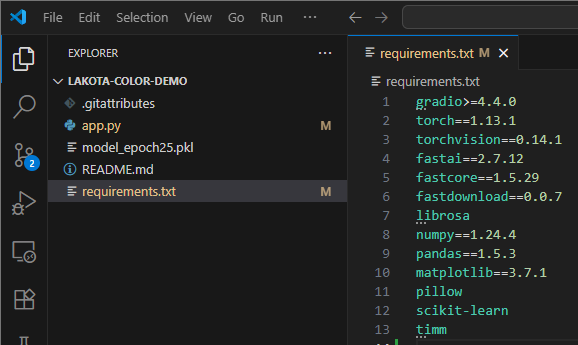

Notice that the ***Source Control*** tab on the far left has the number 2 on it. This indicates that there are 2 files that need to be commited to the repository and synced.

Now that you have made the changes, use the source control panel to commit the changes. 

***DO NOT FORGET TO INCLUDE A MESSAGE WITH THE COMMIT, VS CODE WILL HANG UP. TO RECOVER, MAKE SURE YOUR FILES ARE SAVED, CLOSE VS CODE, AND REOPEN IT.***